## Part 1: Setup and Initialization
This section sets the groundwork for your event study by importing all necessary libraries and defining the core data management classes. These classes (DataLake, DataCatalog, DataWorkbench, IntradayDataModel, NewsDataModel, etc.) are pivotal for organizing, storing, and processing your datasets. Additionally, a utility function display_dataframe is defined to aid in inspecting data at various stages.

* Importing Essential Libraries: Incorporate necessary Python libraries for data manipulation, API interactions, machine learning, and visualization.
* Defining Data Management Components: Establish the foundational classes (DataLake, DataCatalog, DataWorkbench, etc.) to handle data storage, retrieval, and transformation.
* Initializing Data Structures: Set up the data management systems that will facilitate the seamless flow of data through various stages of the analysis.

In [13]:
'''
yfinance version must be <= 0.2.41
Event Study is based off the recent 2024 US Presidential Election. The goal is to analyze the stock market's reaction to the election results.
Password for reading/writing data: '1234'
'''

"\nyfinance version must be <= 0.2.41\nEvent Study is based off the recent 2024 US Presidential Election. The goal is to analyze the stock market's reaction to the election results.\nPassword for reading/writing data: '1234'\n"

In [1]:
# Import necessary libraries
import sqlite3
import pandas as pd
import numpy as np
from newsapi import NewsApiClient
import os
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
from sys_comp import DataLake, DataCategory, DataCatalog, DataWorkbench, BaseDataModel, IntradayDataModel, NewsDataModel

# Example display function replacement (from sys_comp)
def display_dataframe(name, dataframe):
    """
    Displays the name of the DataFrame and its first few rows.

    :param name: A string representing the name or title of the DataFrame.
    :param dataframe: The pandas DataFrame to be displayed.
    """
    print(f"\n{name}:")
    print(dataframe.head())

# Initialize DataLake, DataCatalog, and DataWorkbench
data_lake = DataLake()
data_catalog = DataCatalog(data_lake)
data_workbench = DataWorkbench()

# Load API Key
api_key = os.getenv('NEWSAPI_KEY') # 환경 변수 설정
auth = NewsApiClient(api_key='d5b0dce5cb5543b6aa800e8c60689d8c')

print("Data Lake, Data Catalog, and Data Workbench have been initialized successfully.")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data Lake, Data Catalog, and Data Workbench have been initialized successfully.


## Part 2: Data Retrieval
This segment handles the acquisition of both news articles and intraday stock data. The news articles are fetched using the NewsAPI, targeting the keyword "Trump" over a specified period. Simultaneously, intraday stock data for AAPL and MSFT is downloaded using yfinance, providing granular price and volume information essential for the event study.

* Fetching News Articles: Retrieve news articles related to "Trump" over a 1-month look-back period leading up to the event date and beyond.
* Downloading Intraday Stock Data: Obtain 15-minute interval intraday stock data for Apple Inc. (AAPL) and Microsoft Corporation (MSFT), ensuring the inclusion of the event date within the data range.


In [2]:

# Define the event day
event_day = '2024-11-05'
# Define the end date as today
today = datetime.now().strftime('%Y-%m-%d')
# Calculate the start date (1 month before the event day)
start_date = (datetime.now() - pd.DateOffset(months=1)).strftime('%Y-%m-%d')

# Fetch news articles related to "Trump" over the past month up to the event day
news_queries = [
    {"q": "Trump", "from_param": start_date, "to": event_day},
    {"q": "Trump", "from_param": event_day, "to": today}
]

news_articles = []
for query in news_queries:
    try:
        news = auth.get_everything(
            q=query["q"],
            from_param=query["from_param"],
            to=query["to"],
            language="en",
            sort_by="relevancy",
            page_size=100  # Increased page size for more articles
        )
        news_articles.extend(news['articles'])
        print(f"Fetched {len(news['articles'])} articles from {query['from_param']} to {query['to']}.")
    except Exception as e:
        print(f"Error fetching news for {query['from_param']} to {query['to']}: {e}")

# Fetch intraday stock data for AAPL and MSFT
try:
    aapl = yf.download(tickers='AAPL', period='1mo', interval='15m')  # Adjusted period to include event day
    aapl['timestamp'] = aapl.index
    msft = yf.download(tickers='MSFT', period='1mo', interval='15m')
    msft['timestamp'] = msft.index
    print("Successfully fetched intraday stock data for AAPL and MSFT.")
except Exception as e:
    print(f"Error fetching stock data: {e}")


Fetched 100 articles from 2024-10-16 to 2024-11-05.
Fetched 100 articles from 2024-11-05 to 2024-11-16.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Successfully fetched intraday stock data for AAPL and MSFT.


## Part 3: Storing and Cataloging Data
This section ensures that the fetched data is securely stored and well-organized. The store_with_password function abstracts the password-protected storage mechanism, allowing for automated data storage without manual password input. Subsequently, datasets are cataloged with descriptive metadata, facilitating efficient data management and retrieval. Finally, the datasets are integrated into the DataWorkbench, setting the stage for data transformation and analysis.

* Data Storage: Utilize the DataLake class to store raw news articles and processed stock data securely.
* Automating Password Handling: Implement a helper function store_with_password to manage password-protected data storage seamlessly.
* Data Cataloging: Add the stored datasets to the DataCatalog with relevant metadata for easy retrieval and management.
* Data Workbench Integration: Retrieve the datasets from the DataCatalog and store them in the DataWorkbench for subsequent transformations.

In [3]:
# Store raw and processed data in DataLake
# Note: Each store_data call will prompt for a password due to access_control
password = "1234"  # The password expected by access_control

# Define a helper function to handle password input
def store_with_password(data_lake, dataset_name, data, processed=False):
    import builtins
    original_input = builtins.input
    builtins.input = lambda prompt='': password
    try:
        data_lake.store_data(dataset_name, data, processed=processed)
        print(f"Stored dataset '{dataset_name}' successfully.")
    except Exception as e:
        print(f"Error storing dataset '{dataset_name}': {e}")
    finally:
        builtins.input = original_input

# Store raw news articles
store_with_password(data_lake, "news_articles", news_articles, processed=False)

# Store processed stock data
store_with_password(data_lake, "aapl_intraday", aapl, processed=True)
store_with_password(data_lake, "msft_intraday", msft, processed=True)

# Add datasets to DataCatalog with metadata
data_catalog.add_dataset(
    "News", "news_articles",
    data=data_lake.retrieve_data("news_articles", processed=False),
    metadata={"description": "News articles related to Trump", "parameters": ["timestamp", "headline", "sentiment_score", "relevance"]},
    processed=False
)

data_catalog.add_dataset(
    "Equities", "aapl_intraday",
    data=data_lake.retrieve_data("aapl_intraday", processed=True),
    metadata={"description": "Intraday stock data for Apple Inc.", "parameters": ["Open", "High", "Low", "Close", "Adj Close", "Volume"]},
    processed=True
)

data_catalog.add_dataset(
    "Equities", "msft_intraday",
    data=data_lake.retrieve_data("msft_intraday", processed=True),
    metadata={"description": "Intraday stock data for Microsoft Corporation", "parameters": ["Open", "High", "Low", "Close", "Adj Close", "Volume"]},
    processed=True
)

# Retrieve datasets from DataCatalog and store them in DataWorkbench
# This ensures that DataWorkbench has access to the datasets for transformation

# Retrieve 'news_articles'
news_data = data_catalog.retrieve_dataset("news_articles", processed=False)
if news_data:
    data_workbench.store_data("news_articles", news_data)
    print("Stored 'news_articles' in DataWorkbench.")
else:
    print("Failed to retrieve 'news_articles' from DataCatalog.")

# Retrieve 'aapl_intraday'
aapl_data = data_catalog.retrieve_dataset("aapl_intraday", processed=True)
if aapl_data is not None:
    data_workbench.store_data("aapl_intraday", aapl_data)
    print("Stored 'aapl_intraday' in DataWorkbench.")
else:
    print("Failed to retrieve 'aapl_intraday' from DataCatalog.")

# Retrieve 'msft_intraday'
msft_data = data_catalog.retrieve_dataset("msft_intraday", processed=True)
if msft_data is not None:
    data_workbench.store_data("msft_intraday", msft_data)
    print("Stored 'msft_intraday' in DataWorkbench.")
else:
    print("Failed to retrieve 'msft_intraday' from DataCatalog.")

Stored dataset 'news_articles' successfully.
Stored dataset 'aapl_intraday' successfully.
Stored dataset 'msft_intraday' successfully.


Stored 'news_articles' in DataWorkbench.
Stored 'aapl_intraday' in DataWorkbench.
Stored 'msft_intraday' in DataWorkbench.


## Part 4: Loading the FinBERT Model
FinBERT is a specialized BERT model fine-tuned for financial sentiment analysis. This part involves loading the FinBERT tokenizer and model, which are essential for processing and interpreting financial news headlines. Additionally, configuring the computational device (GPU or CPU) ensures that the sentiment analysis operates efficiently, leveraging available hardware resources.

* Model Initialization: Load the FinBERT model and tokenizer from Hugging Face's Transformers library.
* Device Configuration: Determine whether to utilize a GPU or CPU for model inference, optimizing performance based on available hardware.

In [4]:
# Load FinBERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Part 5: Defining the Sentiment Analysis Function
This section defines the core sentiment analysis function leveraging FinBERT. By processing headlines in batches, the function ensures computational efficiency, especially when dealing with extensive datasets. The function maps FinBERT's categorical sentiment labels (Negative, Neutral, Positive) into a continuous scale, facilitating quantitative analysis and visualization.

* Batch Processing: Implement batch processing to efficiently analyze large numbers of headlines.
* Sentiment Mapping: Convert FinBERT's classification outputs into numerical sentiment scores ranging from -1 (most negative) to 1 (most positive).
* Function Encapsulation: Encapsulate the sentiment analysis logic within a reusable function for seamless integration into the data transformation pipeline.

In [5]:

# Define sentiment analysis function using FinBERT
def finbert_sentiment_analysis(headlines, batch_size=32):
    """
    Analyzes sentiment of headlines using FinBERT.
    
    :param headlines: List of news headlines.
    :param batch_size: Number of samples to process at once.
    :return: List of sentiment scores (-1 to 1).
    """
    sentiments = []
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():
        for i in range(0, len(headlines), batch_size):
            batch = headlines[i:i+batch_size]
            inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=128)
            inputs = {key: val.to(device) for key, val in inputs.items()}
            
            outputs = model(**inputs)
            probs = softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            probs = probs.cpu().numpy()
            preds = preds.cpu().numpy()
            
            # Map predictions to sentiment scores
            for pred, prob in zip(preds, probs):
                if pred == 0:  # Negative
                    sentiments.append(-prob[pred])
                elif pred == 1:  # Neutral
                    sentiments.append(0.0)
                elif pred == 2:  # Positive
                    sentiments.append(prob[pred])
    return sentiments



## Part 6: Data Transformation with FinBERT
In this phase, raw news articles undergo transformation to extract essential information and compute sentiment scores using the previously defined FinBERT function. The resultant structured DataFrame includes timestamps, headlines, sentiment scores, and relevance metrics. Post-transformation, the data is securely stored and cataloged, ensuring it’s readily available for subsequent analysis stages.

* Transforming News Data: Convert raw news articles into a structured DataFrame with computed sentiment scores using FinBERT.
* Data Storage and Cataloging: Store the transformed data back into the DataLake and update the DataCatalog with the new dataset for further analysis.

In [6]:

# Update transformation function to use FinBERT
def transform_news_data_finbert(news_raw):
    """
    Transforms raw news articles into a structured DataFrame.
    Computes real sentiment scores using FinBERT.
    """
    print(f"\nTransforming news data. Number of articles: {len(news_raw)}")
    
    if not isinstance(news_raw, list):
        print(f"Expected 'news_raw' to be a list, but got {type(news_raw)}")
        raise TypeError("Expected 'news_raw' to be a list of dictionaries.")
    
    if len(news_raw) > 0 and not isinstance(news_raw[0], dict):
        print(f"Expected articles to be dicts, but first article is {type(news_raw[0])}")
        raise TypeError("Expected 'news_raw' to be a list of dictionaries.")
    
    # Extract headlines and timestamps
    headlines = [article.get('title', '') for article in news_raw]
    timestamps = [pd.to_datetime(article.get('publishedAt', '')) for article in news_raw]
    
    # Perform sentiment analysis
    sentiment_scores = finbert_sentiment_analysis(headlines)
    
    # Construct the DataFrame
    transformed_data = []
    for timestamp, headline, sentiment in zip(timestamps, headlines, sentiment_scores):
        transformed_data.append({
            'timestamp': timestamp,
            'headline': headline,
            'sentiment_score': sentiment,
            'relevance': 0.8  # Placeholder or compute relevance if applicable
        })
    
    news_df = pd.DataFrame(transformed_data)
    return news_df

# Transform news data using FinBERT-based function
try:
    transformed_news_finbert = data_workbench.transform_data("news_articles", transform_news_data_finbert)
    print("Transformed news data with FinBERT successfully.")
except (ValueError, TypeError) as ve:
    print(f"Error during transformation: {ve}")

# Store transformed news data back into DataLake
store_with_password(data_lake, "transformed_news_finbert", transformed_news_finbert, processed=True)

# Add transformed news to DataCatalog
data_catalog.add_dataset(
    "News", "transformed_news_finbert",
    data=data_lake.retrieve_data("transformed_news_finbert", processed=True),
    metadata={"description": "Transformed news articles with FinBERT sentiment scores", "parameters": ["timestamp", "headline", "sentiment_score", "relevance"]},
    processed=True
)

# Initialize News Data Model with FinBERT sentiments
transformed_news_finbert_data = data_catalog.retrieve_dataset("transformed_news_finbert", processed=True)
news_model_finbert = NewsDataModel(
    timestamp=datetime.now(),
    headline=transformed_news_finbert_data['headline'],
    sentiment_score=transformed_news_finbert_data['sentiment_score'],
    relevance=transformed_news_finbert_data['relevance']
)



Transforming news data. Number of articles: 400
Transformed news data with FinBERT successfully.
Stored dataset 'transformed_news_finbert' successfully.


## Part 7: Data Analysis
This phase delves into quantitative analysis. By calculating the VWAP, you gain insights into the average price at which a security has traded throughout the day, weighted by volume. Filtering and grouping the news data based on sentiment scores allows for the examination of daily sentiment trends, which can be correlated with stock price movements to uncover meaningful relationships.

* Calculating VWAP: Compute the Volume Weighted Average Price (VWAP) for AAPL and MSFT using their aggregated intraday data.
* Filtering and Grouping News Data: Filter news articles based on sentiment scores and group them by date to analyze daily sentiment trends.
* Sentiment Trend Analysis: Derive the evolution of average sentiment scores over the specified period, highlighting patterns and potential correlations with stock movements.

In [7]:

# Initialize Quant Data Models
# Aggregate AAPL and MSFT data by 1-hour intervals using DataWorkbench
try:
    aggregated_aapl = data_workbench.aggregate_data("aapl_intraday", 'timestamp', {'Close': 'mean', 'Volume': 'sum'})
    print("Aggregated AAPL data successfully.")
except ValueError as ve:
    print(ve)

try:
    aggregated_msft = data_workbench.aggregate_data("msft_intraday", 'timestamp', {'Close': 'mean', 'Volume': 'sum'})
    print("Aggregated MSFT data successfully.")
except ValueError as ve:
    print(ve)

# For Intraday Data - AAPL
intraday_model_aapl = IntradayDataModel(
    timestamp=datetime.now(),
    price=aggregated_aapl['Close'],
    volume=aggregated_aapl['Volume'],
    symbol="AAPL"
)

# For Intraday Data - MSFT
intraday_model_msft = IntradayDataModel(
    timestamp=datetime.now(),
    price=aggregated_msft['Close'],
    volume=aggregated_msft['Volume'],
    symbol="MSFT"
)

# Calculate VWAP for AAPL
try:
    aapl_vwap = intraday_model_aapl.calculate_vwap(aggregated_aapl)
    print(f"VWAP for AAPL: {aapl_vwap}")
except Exception as e:
    print(f"Error calculating VWAP for AAPL: {e}")

# Calculate VWAP for MSFT
try:
    msft_vwap = intraday_model_msft.calculate_vwap(aggregated_msft)
    print(f"VWAP for MSFT: {msft_vwap}")
except Exception as e:
    print(f"Error calculating VWAP for MSFT: {e}")


Aggregated AAPL data successfully.
Aggregated MSFT data successfully.
VWAP for AAPL: 228.2234545627769
VWAP for MSFT: 420.19767185112556


In [8]:
# Filter news articles with sentiment_score >= 0.4
try:
    filtered_news_finbert = news_model_finbert.filter_by_sentiment(transformed_news_finbert_data, threshold=0.4)
    print(f"Filtered {len(filtered_news_finbert)} news articles with sentiment_score >= 0.4.")
except Exception as e:
    print(f"Error filtering news articles: {e}")

# Group news by date
try:
    grouped_news_finbert = news_model_finbert.group_by_date(filtered_news_finbert)
    print("Grouped news articles by date successfully.")
except Exception as e:
    print(f"Error grouping news articles: {e}")

# Analyze sentiment trend
try:
    sentiment_trend_finbert = news_model_finbert.analyze_sentiment_trend(filtered_news_finbert)
    print("Analyzed sentiment trend successfully.")
except Exception as e:
    print(f"Error analyzing sentiment trend: {e}")


Filtered 88 news articles with sentiment_score >= 0.4.
Grouped news articles by date successfully.
Analyzed sentiment trend successfully.


/Users/gelo/REPOS/python_project_3/sys_comp.py:428: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['timestamp']).dt.date
/Users/gelo/REPOS/python_project_3/sys_comp.py:447: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['timestamp']).dt.date


## Part 8: Visualization
Visualization is pivotal in interpreting and communicating your findings. This section focuses on creating clear and informative plots that showcase the relationship between news sentiment and stock prices. Enhancements include improved date formatting, rotated labels to prevent overlap, and the shading of the event day's trading hours for emphasis. Additionally, sentiment trends and correlations with stock prices are visualized to uncover potential patterns and insights.

* Plotting Sentiment Trends: Visualize the evolution of sentiment scores over the 1-month period.
* Correlation Analysis: Illustrate the relationship between news sentiment and stock closing prices.

In [9]:
# Visualization setup
sns.set(style="whitegrid")

# Define the event date and trading hours
event_day_dt = pd.to_datetime('2024-11-05')
trading_start = pd.Timestamp('2024-11-05 09:30:00')
trading_end = pd.Timestamp('2024-11-05 16:00:00')

aggregated_aapl = aggregated_aapl.reset_index()
aggregated_aapl['timestamp'] = pd.to_datetime(aggregated_aapl['timestamp'])
aggregated_msft = aggregated_msft.reset_index()
aggregated_msft['timestamp'] = pd.to_datetime(aggregated_aapl['timestamp'])
display(aggregated_aapl)

,timestamp,Close,Volume
0,2024-10-16 09:30:00,230.684998,10947460
1,2024-10-16 09:45:00,230.078598,4008302
2,2024-10-16 10:00:00,230.490005,4027528
3,2024-10-16 10:15:00,230.729706,2270460
4,2024-10-16 10:30:00,230.294998,2120858
...,...,...,...
593,2024-11-15 14:45:00,224.820007,1116168
594,2024-11-15 15:00:00,224.875000,2097018
595,2024-11-15 15:15:00,224.809998,1795060
596,2024-11-15 15:30:00,224.800003,2092156


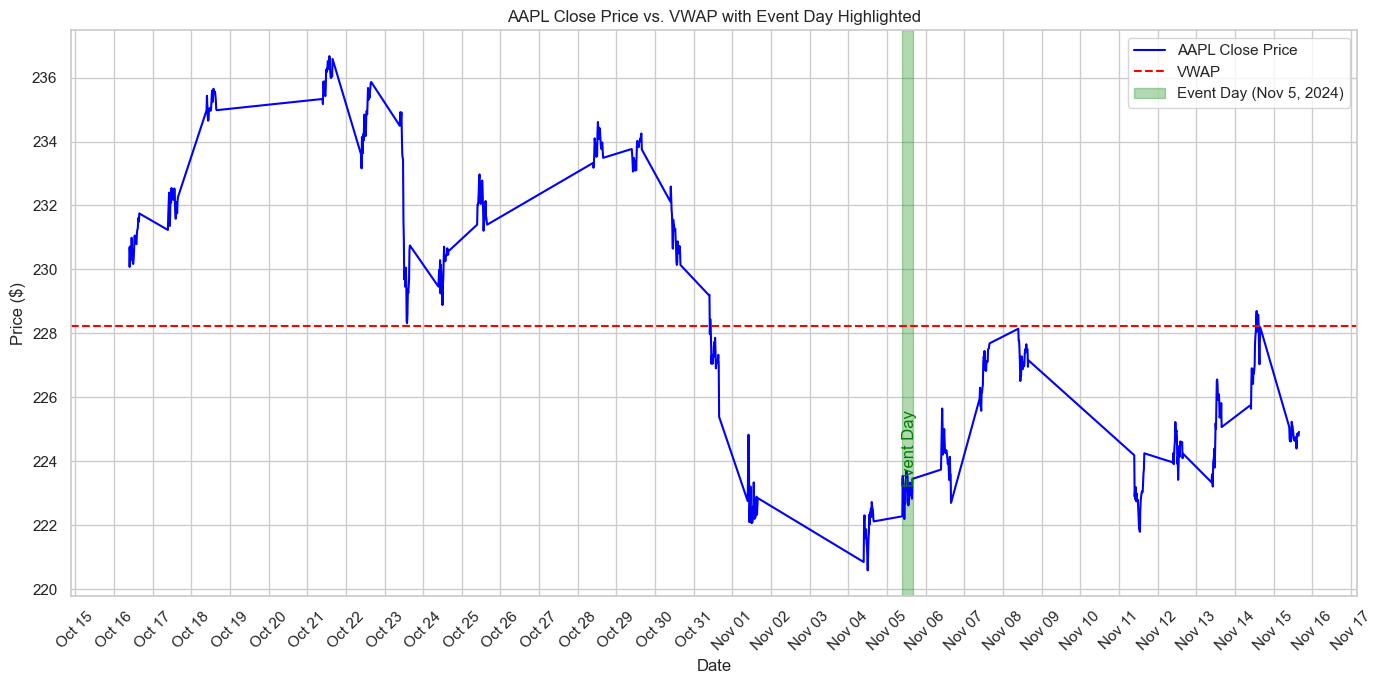

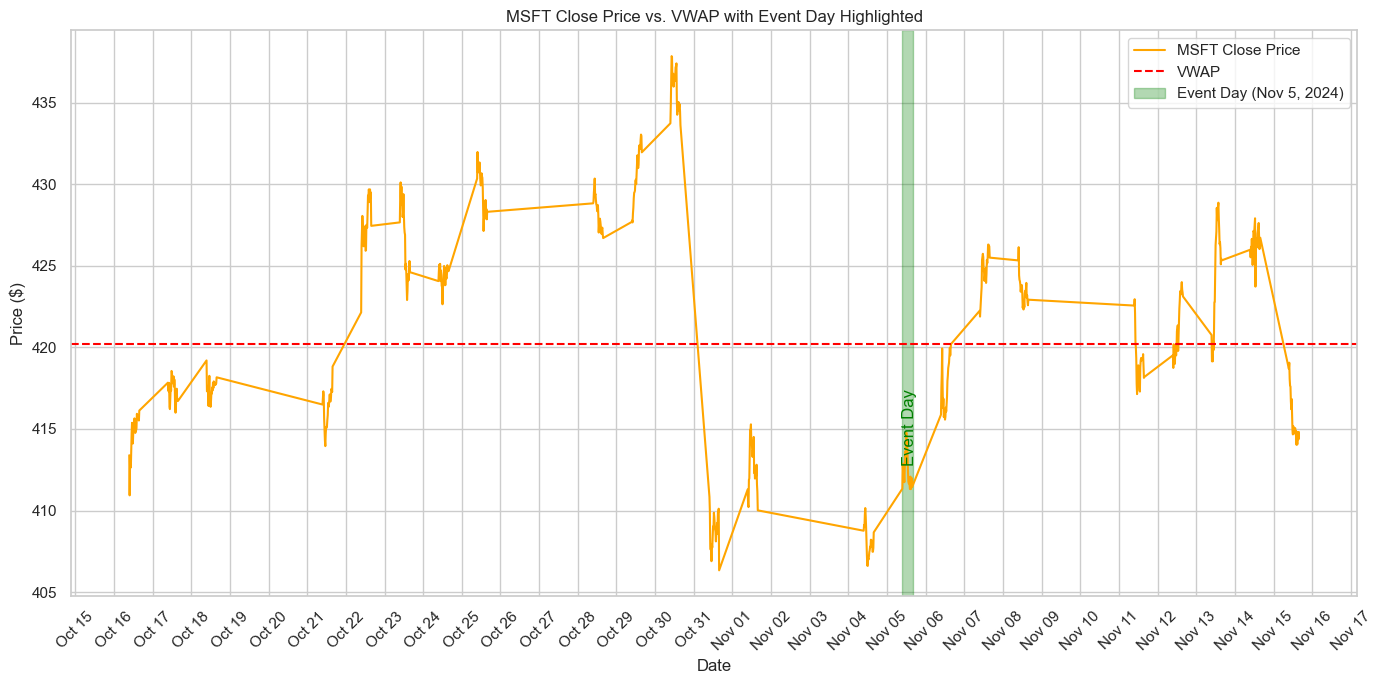

In [10]:

# Plot VWAP for AAPL with improved x-axis and event day highlighting
plt.figure(figsize=(14, 7))
# Plot AAPL Close Price
plt.plot(aggregated_aapl['timestamp'], aggregated_aapl['Close'], label='AAPL Close Price', color='blue')
# Plot VWAP as a horizontal line
plt.axhline(y=aapl_vwap, color='red', linestyle='--', label='VWAP')
# Highlight the entire event day trading hours using axvspan
plt.axvspan(trading_start, trading_end, color='green', alpha=0.3, label='Event Day (Nov 5, 2024)')
# Annotate the event day
plt.text(trading_start, plt.ylim()[1]*0.95, 'Event Day', rotation=90, color='green', verticalalignment='top')
# Formatting the x-axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Major ticks on each day
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format as 'Nov 05'
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('AAPL Close Price vs. VWAP with Event Day Highlighted')
plt.legend()
plt.grid(True)
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot VWAP for MSFT with improved x-axis and event day highlighting
plt.figure(figsize=(14, 7))
# Plot MSFT Close Price
plt.plot(aggregated_msft['timestamp'], aggregated_msft['Close'], label='MSFT Close Price', color='orange')
# Plot VWAP as a horizontal line
plt.axhline(y=msft_vwap, color='red', linestyle='--', label='VWAP')
# Highlight the entire event day trading hours using axvspan
plt.axvspan(trading_start, trading_end, color='green', alpha=0.3, label='Event Day (Nov 5, 2024)')
# Annotate the event day
plt.text(trading_start, plt.ylim()[1]*0.95, 'Event Day', rotation=90, color='green', verticalalignment='top')
# Formatting the x-axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Major ticks on each day
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format as 'Nov 05'
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('MSFT Close Price vs. VWAP with Event Day Highlighted')
plt.legend()
plt.grid(True)
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Comments:
* Prices seem to rally leading up to and after the event day

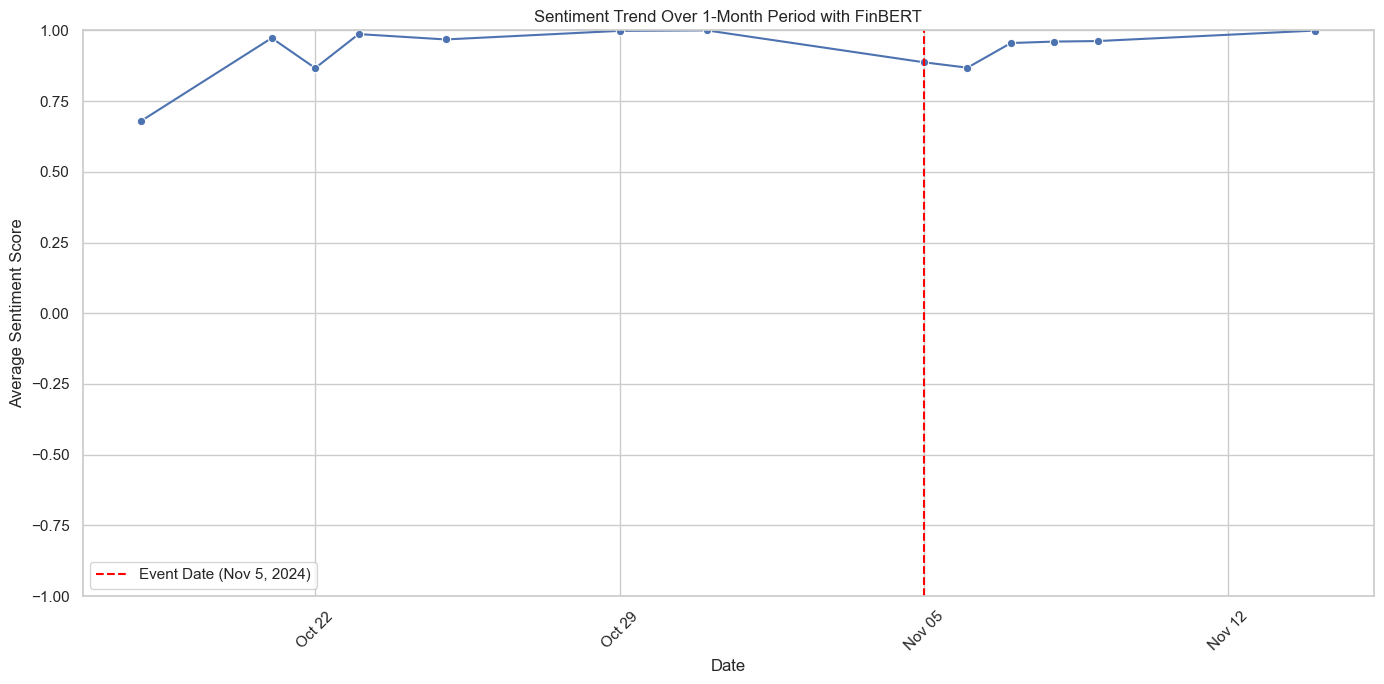

In [11]:
# Plot Sentiment Trend with 1-Month Look-Back using FinBERT scores
plt.figure(figsize=(14, 7))
sns.lineplot(data=sentiment_trend_finbert, x='date', y='sentiment_score', marker='o')
plt.title('Sentiment Trend Over 1-Month Period with FinBERT')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.ylim(-1, 1)  # Sentiment scores range from -1 to 1
plt.axvline(event_day_dt, color='red', linestyle='--', label='Event Date (Nov 5, 2024)')
plt.legend()
plt.grid(True)
# Improve x-axis date formatting
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Comments:
* During that period, we can see that the sentiment scores are relatively high
* Given that these are positive-trump sentiment scores, a high score suggests bullishness in the stock market as people expect Trump to win and might be pricing that in
* Especially since Trump is pro-business/growth

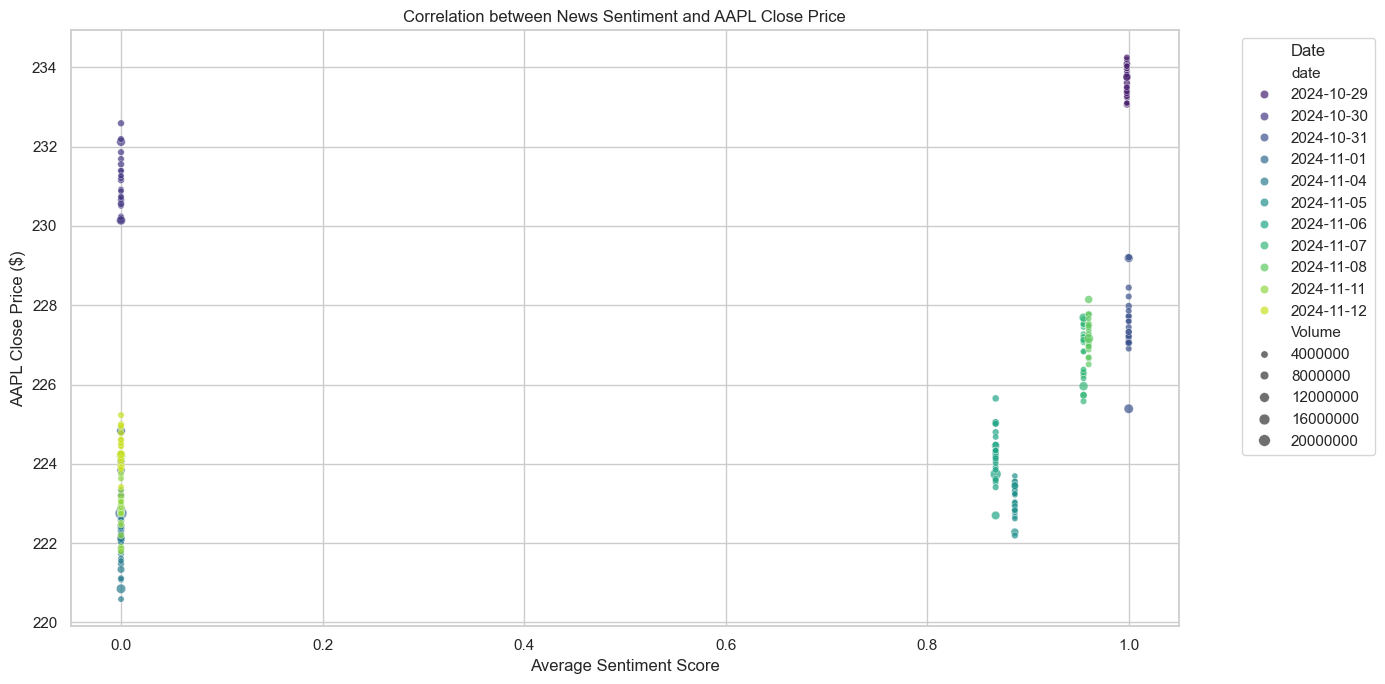

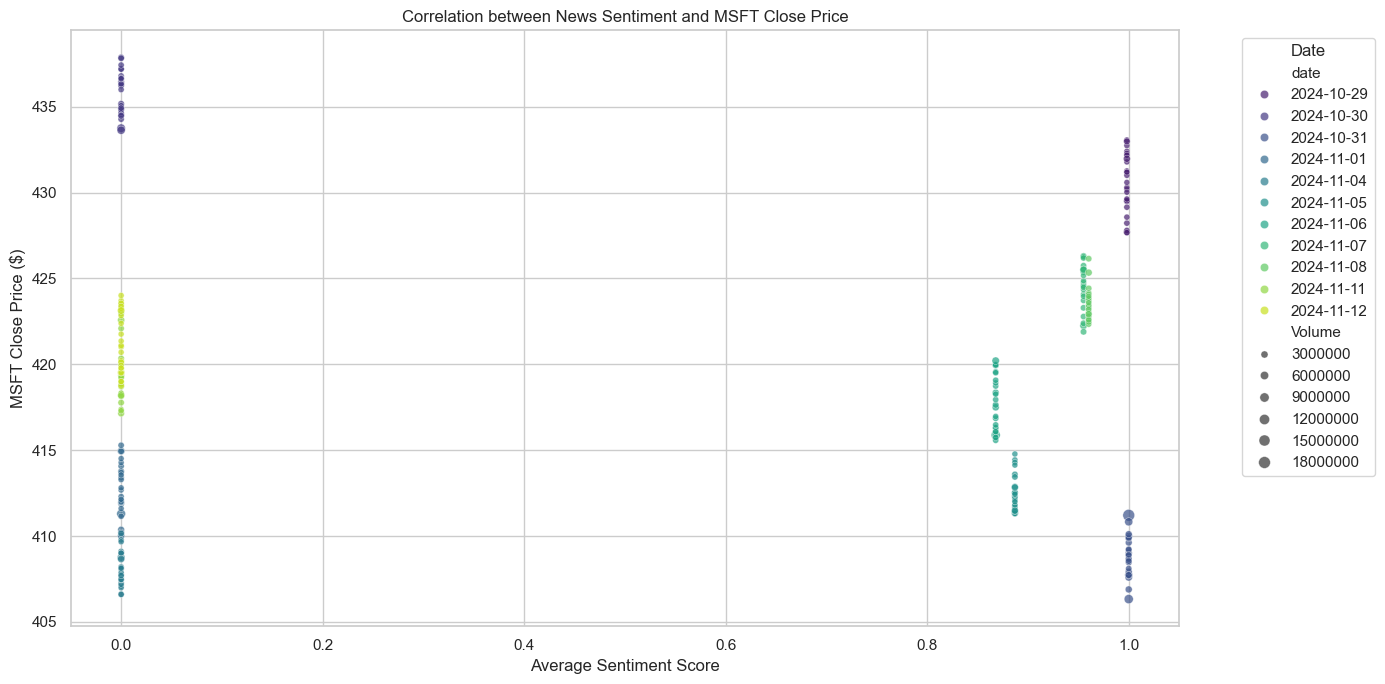

In [12]:
start = pd.to_datetime('2024-10-29')
end = pd.to_datetime('2024-11-13')

# Correlation between Sentiment and AAPL Close Price
# Merge aggregated AAPL data with grouped news on date
aggregated_aapl['date'] = pd.to_datetime(aggregated_aapl['timestamp']).dt.date
merged_aapl = pd.merge(aggregated_aapl, grouped_news_finbert, on='date', how='left').fillna({'article_count': 0, 'sentiment_score': 0})

plt.figure(figsize=(14, 7))
sns.scatterplot(data=merged_aapl.loc[(merged_aapl['timestamp']>start) & (merged_aapl['timestamp'] < end)], x='sentiment_score', y='Close', size='Volume', hue='date', palette='viridis', alpha=0.7)
plt.title('Correlation between News Sentiment and AAPL Close Price')
plt.xlabel('Average Sentiment Score')
plt.ylabel('AAPL Close Price ($)')
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Correlation between Sentiment and MSFT Close Price
# Merge aggregated MSFT data with grouped news on date
aggregated_msft['date'] = pd.to_datetime(aggregated_msft['timestamp']).dt.date
merged_msft = pd.merge(aggregated_msft, grouped_news_finbert, on='date', how='left').fillna({'article_count': 0, 'sentiment_score': 0})

plt.figure(figsize=(14, 7))
sns.scatterplot(data=merged_msft.loc[(merged_msft['timestamp']>start) & (merged_msft['timestamp'] < end)], x='sentiment_score', y='Close', size='Volume', hue='date', palette='viridis', alpha=0.7)
plt.title('Correlation between News Sentiment and MSFT Close Price')
plt.xlabel('Average Sentiment Score')
plt.ylabel('MSFT Close Price ($)')
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Comments:
* We graphed 5 days before and after the event day (darker before, lighter after)
* We counted the event day as part of the before period due to the election results being released after the conclusion of the trading day
* We can see that on the days further (both before and after the event day) from the event, the sentiment scores are closer to 0, indicating neutral sentiment
* Closer to the event, we have more positive Trump sentiment, which can help to explain the movement in the stock.